In [ ]:
#Basic Initialization

#Code:
 #setting path in colab
 #mount the drive first
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
import os

#set the working directory 

root_dir = "/content/drive/My Drive/"

#choose the project folder
project_folder = "CIS680HW/HW4/"

#define a function to create and set the working directory
def create_and_set_working_directory(project_folder):
  #check if the project folder exists. if not, make one.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
  
  #change the OS path to project folder as working directory
  os.chdir(root_dir + project_folder)

  #create a test file in the working directory and see if it shows up at the right place
  !touch 'new_file_test.txt'
  print('working directory' + root_dir + project_folder + \
        "empty text file created. You can also run !pwd command to confirm working directory.")

create_and_set_working_directory(project_folder)

Mounted at /content/drive/
working directory/content/drive/My Drive/CIS680HW/HW4/empty text file created. You can also run !pwd command to confirm working directory.


In [ ]:
cd /content/drive/MyDrive/CIS680HW/HW4


/content/drive/MyDrive/CIS680HW/HW4


In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1pW-dS5VURWlYnyF8au7Gtt4gHC_yKKap/HW4'

In [ ]:
from rpn import *
from dataset import BuildDataLoader, BuildDataset
import torch.optim as optim

In [ ]:
imgs_path = root_dir + 'CIS680HW' + '/HW3/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
torch.random.manual_seed(1)    
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
batch_size = 8
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
rpn_net = RPNHead().to(device)
rpn_net2 = RPNHead().to(device)
optimizer = optim.SGD(rpn_net.parameters(),lr = 0.002,weight_decay=1.0e-4,momentum=0.90)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,35], gamma=0.20)
epochs = 40
batch_loss_list = []
batch_loss_c_list = []
batch_loss_r_list = []
batch_loss_list_test = []
batch_loss_c_list_test = []
batch_loss_r_list_test = []

for e in range(epochs):
    batch_loss = 0
    batch_loss_c = 0
    batch_loss_r = 0
    print("Epoch {}".format(e))
    #optimizer = optim.SGD(rpn_net.parameters(),lr = 0.001,weight_decay=1.0e-4,momentum=0.90)
    for i, batch in enumerate(train_loader):
        #pdb.set_trace()
        X = batch['images'].to(device)
        images = batch['images'][0,:,:,:]
        indexes = batch['indexes']
        boxes = batch['bboxes']
        gt, ground_coord = rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:]) 
        cls_out, reg_out = rpn_net.forward(X)
        loss, loss_c, loss_r = rpn_net.compute_loss(cls_out, reg_out, gt.to(device), ground_coord.to(device),effective_batch=batch_size*16)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss +=loss.cpu().item()
        batch_loss_c += loss_c.cpu().item()
        batch_loss_r += loss_r.cpu().item()
        
        if i % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.
                  format(e, i * len(batch['images']), train_size,
                        100. * i / len(train_loader), loss.cpu().item()))

    print("Total Loss, Loss Class, Loss R: {} {}  {}".format(batch_loss,batch_loss_c,batch_loss_r))
    batch_loss_test = 0
    batch_loss_c_test = 0
    batch_loss_r_test = 0
    for i, batch in enumerate(test_loader):
      X = batch['images'].to(device)
      images = batch['images'][0,:,:,:]
      indexes = batch['indexes']
      boxes = batch['bboxes']
      rpn_net.eval()
      cls_out, reg_out = rpn_net.forward(X)
      gt, ground_coord = rpn_net2.create_batch_truth(boxes,indexes,images.shape[-2:]) 
      loss, loss_c, loss_r = rpn_net.compute_loss(cls_out, reg_out, gt.to(device), ground_coord.to(device),effective_batch=batch_size*16)
      batch_loss_test +=loss.cpu().item()
      batch_loss_c_test += loss_c.cpu().item()
      batch_loss_r_test += loss_r.cpu().item()

    batch_loss_list.append(batch_loss/len(train_loader))
    batch_loss_c_list.append(batch_loss_c/len(train_loader))
    batch_loss_r_list.append(batch_loss_r/len(train_loader))
    batch_loss_list_test.append(batch_loss_test/len(test_loader))
    batch_loss_c_list_test.append(batch_loss_c_test/len(test_loader))
    batch_loss_r_list_test.append(batch_loss_r_test/len(test_loader))
    scheduler.step()
torch.save(rpn_net.state_dict(), './model1_vs_bs8_efbs16.pth')
np.save('batch_loss_bs8_efbs16.npy', np.array(batch_loss_list))
np.save('batch_loss_c_bs8_efbs16.npy', np.array(batch_loss_c_list))
np.save('batch_loss_r_bs8_efbs16.npy', np.array(batch_loss_r_list))
np.save('batch_loss_test_bs8_efbs16.npy', np.array(batch_loss_list_test))
np.save('batch_loss_c_test_bs8_efbs16.npy', np.array(batch_loss_c_list_test))
np.save('batch_loss_r_test_bs8_efbs16.npy', np.array(batch_loss_r_list_test))

Epoch 0
Train Epoch: 0 [0/2612 (0%)]	Loss: 1.826943
Train Epoch: 0 [800/2612 (31%)]	Loss: 1.364974
Train Epoch: 0 [1600/2612 (61%)]	Loss: 1.051685
Train Epoch: 0 [2400/2612 (92%)]	Loss: 1.091757
Total Loss, Loss Class, Loss R: 458.40733432769775 209.77472627162933  124.31630393862724
Epoch 1
Train Epoch: 1 [0/2612 (0%)]	Loss: 2.616292
Train Epoch: 1 [800/2612 (31%)]	Loss: 1.332646
Train Epoch: 1 [1600/2612 (61%)]	Loss: 1.900584
Train Epoch: 1 [2400/2612 (92%)]	Loss: 1.049800
Total Loss, Loss Class, Loss R: 449.4630475640297 214.27139842510223  117.59582431614399
Epoch 2
Train Epoch: 2 [0/2612 (0%)]	Loss: 1.076334
Train Epoch: 2 [800/2612 (31%)]	Loss: 2.452153
Train Epoch: 2 [1600/2612 (61%)]	Loss: 2.482204
Train Epoch: 2 [2400/2612 (92%)]	Loss: 1.487600
Total Loss, Loss Class, Loss R: 441.27188646793365 206.35466760396957  117.45860953629017
Epoch 3
Train Epoch: 3 [0/2612 (0%)]	Loss: 1.104938
Train Epoch: 3 [800/2612 (31%)]	Loss: 1.187751
Train Epoch: 3 [1600/2612 (61%)]	Loss: 1.117506

In [ ]:
torch.save(rpn_net.state_dict(), './model1_vs.pth')

Part 5 and Part 6 outputs

In [ ]:
from rpn import *
from dataset import BuildDataLoader, BuildDataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb

def visualise_labels(images, labels, masks, bboxes ):
    plt.figure()
    plt.axes()

    plot=images.numpy()
    
    plot= np.moveaxis(plot,0,-1)
    print(plot.shape)
    print(len(labels))
    for i in range(len(labels)):
        show_mask= masks[0][i].numpy()
        print(show_mask.shape)
        if labels[i]==0:
          pass
        if labels[i]==1:
            plot[:,:,0] += show_mask*3 
        if labels[i]==2:
            plot[:,:,1] += show_mask*3 
        if labels[i]==3:
            plot[:,:,2] += show_mask*3 

    plt.imshow(np.clip(plot,0,1))

    for i in range(len(bboxes)):
        rectangle = plt.Rectangle((bboxes[i][0],bboxes[i][1]), bboxes[i][2]-bboxes[i][0],bboxes[i][3]-bboxes[i][1],fill=False, ec='r', lw=3)
        plt.gca().add_patch(rectangle)

def plot(ground_coord,gt,images,model,string='ground',i=0):
      
        fig,ax=plt.subplots(1,1)
        ax.imshow(images.permute(1,2,0))
        
        find_cor=(gt==1).squeeze().nonzero()
        find_neg=(gt==0).squeeze().nonzero()
        for elem in find_cor:
            coord=torch.squeeze(decoded_coord[elem,:].view(-1, 4))
            anchor=flatten_anchors[elem,:]
            col='r'
            rect=patches.Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color=col)
            ax.add_patch(rect)
            rect=patches.Rectangle((anchor[0],anchor[1]),anchor[2]-anchor[0],anchor[3]-anchor[1],fill=False,color='b')
            ax.add_patch(rect)
        plt.show()
        #plt.savefig("./results/"+string+"_truth_visualizations/images_{}".format(i))

[array([[745.35986, 363.8691 , 799.2666 , 517.5133 ]], dtype=float32)]
[array([2])]
(800, 1088, 3)
1
(1088,)


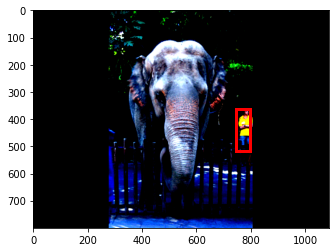

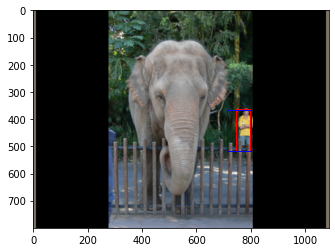

[array([[544.07214, 335.67807, 723.0196 , 795.0855 ]], dtype=float32)]
[array([3])]
(800, 1088, 3)
1
(1088,)


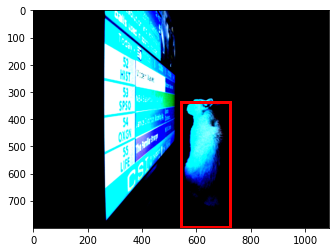

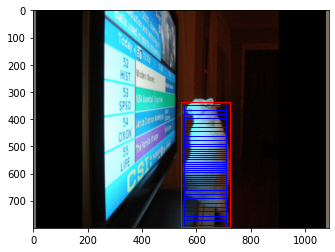

[array([[472.96744, 343.0415 , 600.5084 , 502.2489 ]], dtype=float32)]
[array([2])]
(800, 1088, 3)
1
(1088,)


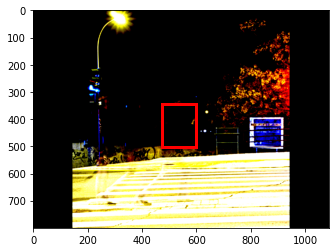

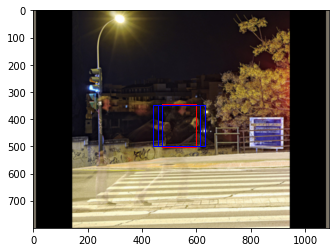

[array([[391.16974,  77.3833 , 699.8333 , 717.1258 ]], dtype=float32)]
[array([3])]
(800, 1088, 3)
1
(1088,)


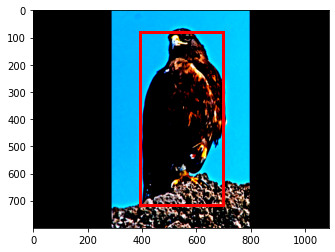

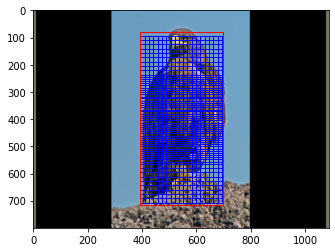

[array([[381.78104, 296.19815, 631.16223, 617.87585],
       [393.50754, 209.69984, 525.499  , 551.7426 ]], dtype=float32)]
[array([1, 2])]
(800, 1088, 3)
2
(1088,)
(1088,)


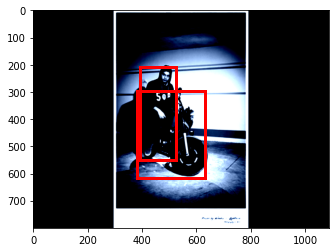

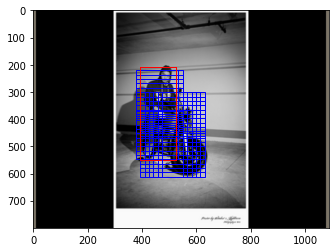

[array([[ 38.27145, 158.88516, 454.60684, 680.8504 ]], dtype=float32)]
[array([3])]
(800, 1088, 3)
1
(1088,)


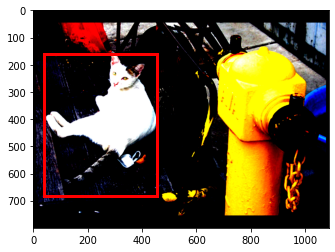

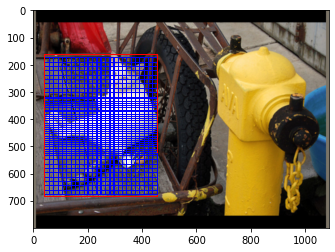

[array([[607.876  , 218.89264, 676.0512 , 501.34464]], dtype=float32)]
[array([2])]
(800, 1088, 3)
1
(1088,)


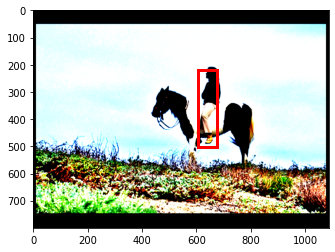

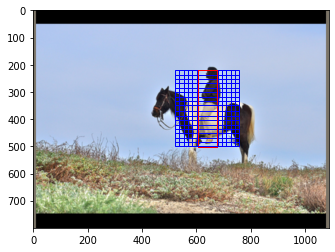

In [ ]:

imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)


# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
torch.random.manual_seed(1)    
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = iter(train_build_loader.loader())
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = iter(test_build_loader.loader())

model = RPNHead()
# push the randomized training data into the dataloader

model.load_state_dict(torch.load('./model6_HG.pth'))
for i,batch in enumerate(test_loader,0):
    images=batch['images'][0,:,:,:]
    indexes=batch['indexes']
    boxes=batch['bboxes']
    print(boxes)
    print(batch['labels'])
    #pdb.set_trace()
    visualise_labels(images.clone(),batch['labels'][0].copy(),batch['masks'][0].clone(),boxes[0].copy())
    gt,ground_coord=model.create_batch_truth(boxes,indexes,images.shape[-2:])

    flatten_coord,flatten_gt,flatten_anchors=output_flattening(ground_coord,gt,model.get_anchors())
    
    # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes
    decoded_coord=output_decoding(flatten_coord,flatten_anchors)
    
    # Plot the image and the anchor boxes with the positive labels and their corresponding ground truth box
    images = transforms.functional.normalize(images,
                                                  [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                                  [1/0.229, 1/0.224, 1/0.225], inplace=False)
    plot(flatten_coord,flatten_gt,images,model,string='ground',i=i)

    ## Forward
    model.eval()
    cls_out, reg_out = model.forward(batch['images'])
    flatten_coord,flatten_gt,flatten_anchors=output_flattening(reg_out,cls_out,model.get_anchors())
    
    # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes for Part 5
    # decoded_coord=output_decoding(flatten_coord,flatten_anchors)
    
    # sort_clas,indices = torch.sort(flatten_gt,dim = 0, descending=True)
    # top_proposals = indices[:20]
    # top_proposals_clas = sort_clas[:20]
    # top_proposals_reg = flat_out_r[top_proposals,:]
    # plot(top_proposals_reg,top_proposals_clas,model,string='prediction',i=i)

    # # part 6 inference results
    # nms_clas_list, nms_prebox_list,pre_nms_clas_list, pre_nms_prebox_list = self.postprocess(cls_out,reg_out)
    # plot(pre_nms_clas_list, pre_nms_prebox_list,model,string='predictionpreNMS',i=i)
    # plot(nms_clas_list,nms_prebox_list,model,string='predictionpostNMS',i=i)
    # # plt.show()

    if(i>5):
        break